# Workbook for working thru the Data Science Pipeline
**Plan | Acquire | Prepare | Model | Deliver**

### What is driving telco customers to churn?

Target variable is churn (categorical)

Are there factors that make a customer more likely to churn or not churn?

H$O$: Features have no predictive value over whether a customer churns or not.

H$A$: Certain features can help predict whether a customer will churn or not.

Goal 1: Identify predictive features, if any, and build a model for predicting churn at Telco

Goal 2: Propose reccomendations for reducing churn based upon analysis

In [1]:
#Imports

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

#standard imports
import numpy as np
import pandas as pd
import os

#visualization tools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier

#env & modules
from env import host, user, password
import acquire
import prepare
import explore

In [2]:
#define get_connection to be used in acquire.py file 
def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the CodeUp db.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [3]:
#define acquire telco data function
def get_telco_data():
    '''
    This function reads in telco data from Codeup database and writes data to
    a csv file, returns df.
    '''
  # filename = 'telco.csv'
  # if os.path.isfile(filename):
  #     return pd.read_csv(filename)
  # else:
  #     # Read fresh data from db into a DataFrame.
    df = pd.read_sql('''
            SELECT *
FROM customers
JOIN internet_service_types USING (internet_service_type_id)
JOIN contract_types USING(contract_type_id)
JOIN payment_types USING (payment_type_id);
            ''', 
            get_connection('telco_churn'))
        
        # Write DataFrame to a csv file.
       # df.to_csv(filename)
          
    return df

In [94]:
telco = get_telco_data()
telco

,payment_type_id,contract_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
0,2,1,3,0030-FNXPP,Female,0,No,No,3,Yes,...,No internet service,No internet service,No internet service,No,19.85,57.2,No,None,Month-to-month,Mailed check
1,2,1,3,0031-PVLZI,Female,0,Yes,Yes,4,Yes,...,No internet service,No internet service,No internet service,No,20.35,76.35,Yes,None,Month-to-month,Mailed check
2,1,1,3,0098-BOWSO,Male,0,No,No,27,Yes,...,No internet service,No internet service,No internet service,Yes,19.40,529.8,No,None,Month-to-month,Electronic check
3,1,1,3,0107-WESLM,Male,0,No,No,1,Yes,...,No internet service,No internet service,No internet service,Yes,19.85,19.85,Yes,None,Month-to-month,Electronic check
4,3,1,3,0114-RSRRW,Female,0,Yes,No,10,Yes,...,No internet service,No internet service,No internet service,Yes,19.95,187.75,No,None,Month-to-month,Bank transfer (automatic)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,4,3,1,9919-FZDED,Male,1,Yes,No,72,Yes,...,No,Yes,Yes,Yes,84.10,5981.65,No,DSL,Two year,Credit card (automatic)
7039,3,3,1,9926-PJHDQ,Female,0,Yes,Yes,72,Yes,...,No,Yes,Yes,Yes,76.80,5468.45,No,DSL,Two year,Bank transfer (automatic)
7040,2,3,1,9928-BZVLZ,Female,0,No,No,12,No,...,Yes,No,Yes,No,49.85,552.1,No,DSL,Two year,Mailed check
7041,2,3,1,9993-LHIEB,Male,0,Yes,Yes,67,Yes,...,Yes,No,Yes,No,67.85,4627.65,No,DSL,Two year,Mailed check


In [95]:
telco.payment_type_id.replace({1: 0, 2: 0, 3: 1, 4: 1}, inplace=True)

In [96]:
telco.rename(columns={'payment_type_id': 'auto_bill_pay'}, inplace=True)

In [97]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   auto_bill_pay             7043 non-null   int64  
 1   contract_type_id          7043 non-null   int64  
 2   internet_service_type_id  7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [98]:
telco.internet_service_type.value_counts()

Fiber optic    3096
DSL            2421
None           1526
Name: internet_service_type, dtype: int64

In [99]:
telco.contract_type.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: contract_type, dtype: int64

In [100]:
telco.payment_type.value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_type, dtype: int64

In [101]:
telco['total_charges'] = telco.total_charges.replace(' ', 0.0)
telco['total_charges'] = telco.total_charges.astype('float64')

In [102]:
telco.dtypes

auto_bill_pay                 int64
contract_type_id              int64
internet_service_type_id      int64
customer_id                  object
gender                       object
senior_citizen                int64
partner                      object
dependents                   object
tenure                        int64
phone_service                object
multiple_lines               object
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
paperless_billing            object
monthly_charges             float64
total_charges               float64
churn                        object
internet_service_type        object
contract_type                object
payment_type                 object
dtype: object

In [104]:
telco.head()

,auto_bill_pay,contract_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
0,0,1,3,0030-FNXPP,Female,0,No,No,3,Yes,...,No internet service,No internet service,No internet service,No,19.85,57.20,No,None,Month-to-month,Mailed check
1,0,1,3,0031-PVLZI,Female,0,Yes,Yes,4,Yes,...,No internet service,No internet service,No internet service,No,20.35,76.35,Yes,None,Month-to-month,Mailed check
2,0,1,3,0098-BOWSO,Male,0,No,No,27,Yes,...,No internet service,No internet service,No internet service,Yes,19.40,529.80,No,None,Month-to-month,Electronic check
3,0,1,3,0107-WESLM,Male,0,No,No,1,Yes,...,No internet service,No internet service,No internet service,Yes,19.85,19.85,Yes,None,Month-to-month,Electronic check
4,1,1,3,0114-RSRRW,Female,0,Yes,No,10,Yes,...,No internet service,No internet service,No internet service,Yes,19.95,187.75,No,None,Month-to-month,Bank transfer (automatic)


In [105]:
def update_total_charges(df):
    for n in df.total_charges:
        if n == 0:
            data.replace({
            'total_charges': {
        0: 'monthly_charges'
                        }
                        })
        else:
            n == n
    return df

In [106]:
telco['total_charges'] = np.where(telco['total_charges']==0, telco['monthly_charges'] , telco['total_charges'])

In [107]:
telco[telco.tenure > 1].sample(10)

,auto_bill_pay,contract_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
5034,0,2,1,4578-PHJYZ,Male,0,Yes,Yes,52,Yes,...,Yes,Yes,No,Yes,68.75,3482.85,No,DSL,One year,Electronic check
3756,1,1,1,8904-OPDCK,Male,1,Yes,No,54,No,...,No,No,No,Yes,24.95,1364.75,No,DSL,Month-to-month,Bank transfer (automatic)
5364,1,3,3,0374-FIUCA,Male,0,Yes,No,65,Yes,...,No internet service,No internet service,No internet service,Yes,20.40,1414.45,No,None,Two year,Credit card (automatic)
2217,1,1,2,7852-LECYP,Male,1,Yes,No,13,Yes,...,No,No,Yes,No,93.80,1261.00,No,Fiber optic,Month-to-month,Credit card (automatic)
952,0,1,2,2079-FBMZK,Female,0,No,No,6,Yes,...,No,No,No,Yes,69.25,418.40,Yes,Fiber optic,Month-to-month,Mailed check
2183,0,1,2,7638-QVMVY,Female,0,No,No,7,Yes,...,No,Yes,No,Yes,79.00,522.95,Yes,Fiber optic,Month-to-month,Electronic check
5693,1,3,3,5334-AFQJB,Male,1,No,No,72,Yes,...,No internet service,No internet service,No internet service,Yes,25.10,1789.90,No,None,Two year,Credit card (automatic)
5461,0,3,3,1790-NESIO,Female,0,No,No,13,Yes,...,No internet service,No internet service,No internet service,Yes,20.40,261.30,No,None,Two year,Mailed check
1415,1,1,2,4138-NAXED,Male,0,No,No,51,Yes,...,No,No,No,No,81.00,4085.75,No,Fiber optic,Month-to-month,Bank transfer (automatic)
6632,1,3,1,3745-HRPHI,Male,0,Yes,Yes,66,No,...,Yes,Yes,Yes,No,54.65,3632.00,No,DSL,Two year,Bank transfer (automatic)


In [108]:
telco.total_charges.describe()

count    7043.000000
mean     2279.798992
std      2266.730170
min        18.800000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: total_charges, dtype: float64

In [109]:
telco[telco.total_charges == 0]

,auto_bill_pay,contract_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type


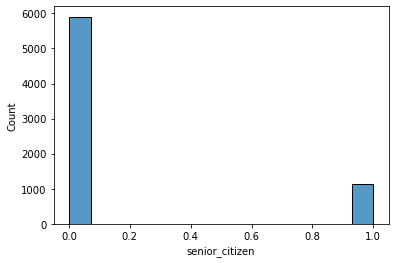

In [110]:
#Check the distribution of senior citizens
sns.histplot(data=telco.senior_citizen);

In [111]:
telco.describe()

,auto_bill_pay,contract_type_id,internet_service_type_id,senior_citizen,tenure,monthly_charges,total_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.435326,1.690473,1.872923,0.162147,32.371149,64.761692,2279.798992
std,0.495835,0.833755,0.737796,0.368612,24.559481,30.090047,2266.730170
min,0.000000,1.000000,1.000000,0.000000,0.000000,18.250000,18.800000
25%,0.000000,1.000000,1.000000,0.000000,9.000000,35.500000,398.550000
50%,0.000000,1.000000,2.000000,0.000000,29.000000,70.350000,1394.550000
75%,1.000000,2.000000,2.000000,0.000000,55.000000,89.850000,3786.600000
max,1.000000,3.000000,3.000000,1.000000,72.000000,118.750000,8684.800000


In [112]:
#List of all the columns
cols = telco.columns.to_list()
cols

['auto_bill_pay',
 'contract_type_id',
 'internet_service_type_id',
 'customer_id',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'churn',
 'internet_service_type',
 'contract_type',
 'payment_type']

In [113]:
#List of all numeric columns 
telco.select_dtypes(include='int64').columns.to_list()

['auto_bill_pay',
 'contract_type_id',
 'internet_service_type_id',
 'senior_citizen',
 'tenure']

In [114]:
#Range for all numeric columns
telco_numeric_columns = telco.select_dtypes(include=[np.number])
df_column_range = telco_numeric_columns.max() - telco_numeric_columns.min()
df_column_range

auto_bill_pay                  1.0
contract_type_id               2.0
internet_service_type_id       2.0
senior_citizen                 1.0
tenure                        72.0
monthly_charges              100.5
total_charges               8666.0
dtype: float64

In [115]:
#List of all non numeric columns 
telco.select_dtypes(include='object').columns.to_list()

['customer_id',
 'gender',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'churn',
 'internet_service_type',
 'contract_type',
 'payment_type']

#### Takeaways:
- tenure and monthly charges are the only continuous variables
- duplicate columns exist and will need to be handled

In [116]:
telco.internet_service_type.value_counts()

Fiber optic    3096
DSL            2421
None           1526
Name: internet_service_type, dtype: int64

#### Steps for Prepare:
- Replace all Yes and No values with binary values (0, 1)
- Encode gender, internet_service_type, contract_type, payment_type
- Drop gender, internet_service_type, internet_service_type_id, contract_type_id, payment_type_id
- Replace No phone service with No
- Replace No Internet Service with No
- Deal with missing values in total charges - Create a function for this

In [117]:
telco.replace({'No internet service': 'No', 'No phone service':'No', 'None':'No'}, inplace=True)

In [118]:
telco.replace({'Yes': 1, 'No': 0}, inplace=True)

In [119]:
cols_to_drop = ['internet_service_type_id', 'contract_type_id']
telco.drop(columns=cols_to_drop, inplace=True)

In [120]:
telco

,auto_bill_pay,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
0,0,0030-FNXPP,Female,0,0,0,3,1,0,0,...,0,0,0,0,19.85,57.20,0,0,Month-to-month,Mailed check
1,0,0031-PVLZI,Female,0,1,1,4,1,0,0,...,0,0,0,0,20.35,76.35,1,0,Month-to-month,Mailed check
2,0,0098-BOWSO,Male,0,0,0,27,1,0,0,...,0,0,0,1,19.40,529.80,0,0,Month-to-month,Electronic check
3,0,0107-WESLM,Male,0,0,0,1,1,0,0,...,0,0,0,1,19.85,19.85,1,0,Month-to-month,Electronic check
4,1,0114-RSRRW,Female,0,1,0,10,1,0,0,...,0,0,0,1,19.95,187.75,0,0,Month-to-month,Bank transfer (automatic)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,9919-FZDED,Male,1,1,0,72,1,1,1,...,0,1,1,1,84.10,5981.65,0,DSL,Two year,Credit card (automatic)
7039,1,9926-PJHDQ,Female,0,1,1,72,1,1,0,...,0,1,1,1,76.80,5468.45,0,DSL,Two year,Bank transfer (automatic)
7040,0,9928-BZVLZ,Female,0,0,0,12,0,0,1,...,1,0,1,0,49.85,552.10,0,DSL,Two year,Mailed check
7041,0,9993-LHIEB,Male,0,1,1,67,1,0,1,...,1,0,1,0,67.85,4627.65,0,DSL,Two year,Mailed check


In [121]:
cols_to_encode = ['gender', 'contract_type', 'payment_type']

In [122]:
dummies = pd.get_dummies(telco[cols_to_encode], drop_first=[True])

In [124]:
telco = pd.concat([telco, dummies], axis=1)
telco.head()

,auto_bill_pay,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,...,contract_type_Two year,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,gender_Male,contract_type_One year,contract_type_Two year,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,0,0030-FNXPP,Female,0,0,0,3,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0,0031-PVLZI,Female,0,1,1,4,1,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,0098-BOWSO,Male,0,0,0,27,1,0,0,...,0,0,1,0,1,0,0,0,1,0
3,0,0107-WESLM,Male,0,0,0,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0
4,1,0114-RSRRW,Female,0,1,0,10,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [126]:
telco.drop(columns={'gender','internet_service_type', 'contract_type', 'payment_type'}, inplace=True)

In [127]:
telco.head()

,auto_bill_pay,customer_id,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,contract_type_Two year,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,gender_Male,contract_type_One year,contract_type_Two year,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,0,0030-FNXPP,0,0,0,3,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0,0031-PVLZI,0,1,1,4,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,0098-BOWSO,0,0,0,27,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
3,0,0107-WESLM,0,0,0,1,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
4,1,0114-RSRRW,0,1,0,10,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   auto_bill_pay                         7043 non-null   int64  
 1   customer_id                           7043 non-null   object 
 2   senior_citizen                        7043 non-null   int64  
 3   partner                               7043 non-null   int64  
 4   dependents                            7043 non-null   int64  
 5   tenure                                7043 non-null   int64  
 6   phone_service                         7043 non-null   int64  
 7   multiple_lines                        7043 non-null   int64  
 8   online_security                       7043 non-null   int64  
 9   online_backup                         7043 non-null   int64  
 10  device_protection                     7043 non-null   int64  
 11  tech_support     

#### Questions:
- Are there really no nulls in this dataframe?
- Should reset index to be customer_id, if all ids really are unique?

In [129]:
#Are all the customers ids unique? 
telco['customer_id'].nunique()

7043

In [130]:
#Drop customer id
telco.drop(columns='customer_id', inplace=True)

In [132]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   auto_bill_pay                         7043 non-null   int64  
 1   senior_citizen                        7043 non-null   int64  
 2   partner                               7043 non-null   int64  
 3   dependents                            7043 non-null   int64  
 4   tenure                                7043 non-null   int64  
 5   phone_service                         7043 non-null   int64  
 6   multiple_lines                        7043 non-null   int64  
 7   online_security                       7043 non-null   int64  
 8   online_backup                         7043 non-null   int64  
 9   device_protection                     7043 non-null   int64  
 10  tech_support                          7043 non-null   int64  
 11  streaming_tv     

# Prepping data using prepare functions

In [4]:
telco = get_telco_data()

In [5]:
prepped_telco = prepare.prep_data(telco)

In [6]:
prepped_telco.head()

,payment_type_id,contract_type_id,internet_service_type_id,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,gender_Male
0,2,1,3,0,0,0,3,1,0,0,0,0,0,0,0,0,19.85,57.20,0,0
1,2,1,3,0,1,1,4,1,0,0,0,0,0,0,0,0,20.35,76.35,1,0
2,1,1,3,0,0,0,27,1,0,0,0,0,0,0,0,1,19.40,529.80,0,1
3,1,1,3,0,0,0,1,1,0,0,0,0,0,0,0,1,19.85,19.85,1,1
4,3,1,3,0,1,0,10,1,0,0,0,0,0,0,0,1,19.95,187.75,0,0


In [7]:
prepped_telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   contract_type_id          7043 non-null   int64  
 2   internet_service_type_id  7043 non-null   int64  
 3   senior_citizen            7043 non-null   int64  
 4   partner                   7043 non-null   int64  
 5   dependents                7043 non-null   int64  
 6   tenure                    7043 non-null   int64  
 7   phone_service             7043 non-null   int64  
 8   multiple_lines            7043 non-null   int64  
 9   online_security           7043 non-null   int64  
 10  online_backup             7043 non-null   int64  
 11  device_protection         7043 non-null   int64  
 12  tech_support              7043 non-null   int64  
 13  streaming_tv              7043 non-null   int64  
 14  streamin

In [8]:
prepped_telco.describe()

,payment_type_id,contract_type_id,internet_service_type_id,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,gender_Male
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2.315633,1.690473,1.872923,0.162147,0.483033,0.299588,32.371149,0.903166,0.421837,0.286668,0.344881,0.343888,0.290217,0.384353,0.387903,0.592219,64.761692,2279.798992,0.265370,0.504756
std,1.148907,0.833755,0.737796,0.368612,0.499748,0.458110,24.559481,0.295752,0.493888,0.452237,0.475363,0.475038,0.453895,0.486477,0.487307,0.491457,30.090047,2266.730170,0.441561,0.500013
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.500000,398.550000,0.000000,0.000000
50%,2.000000,1.000000,2.000000,0.000000,0.000000,0.000000,29.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,70.350000,1394.550000,0.000000,1.000000
75%,3.000000,2.000000,2.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.850000,3786.600000,1.000000,1.000000
max,4.000000,3.000000,3.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,118.750000,8684.800000,1.000000,1.000000


In [9]:
cat_vars = ['churn', 'senior_citizen', 'partner', 'dependents', 'phone_service', 'multiple_lines','online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'paperless_billing',
       'internet_service_type_id','gender_Male', 'contract_type_id', 
       'payment_type_id']
quant_vars = ['tenure', 'monthly_charges', 'total_charges']

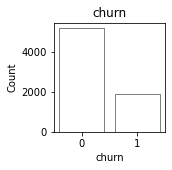

   churn  Count  Percent
0      0   5174    73.46
1      1   1869    26.54
_________________________________________________________________


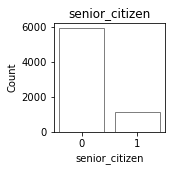

   senior_citizen  Count  Percent
0               0   5901    83.79
1               1   1142    16.21
_________________________________________________________________


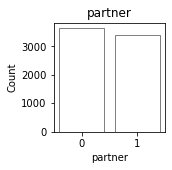

   partner  Count  Percent
0        0   3641     51.7
1        1   3402     48.3
_________________________________________________________________


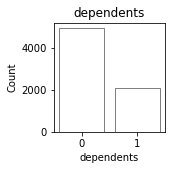

   dependents  Count  Percent
0           0   4933    70.04
1           1   2110    29.96
_________________________________________________________________


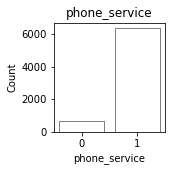

   phone_service  Count  Percent
1              1   6361    90.32
0              0    682     9.68
_________________________________________________________________


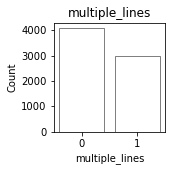

   multiple_lines  Count  Percent
0               0   4072    57.82
1               1   2971    42.18
_________________________________________________________________


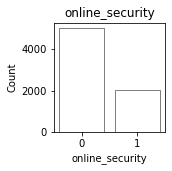

   online_security  Count  Percent
0                0   5024    71.33
1                1   2019    28.67
_________________________________________________________________


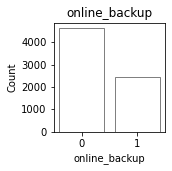

   online_backup  Count  Percent
0              0   4614    65.51
1              1   2429    34.49
_________________________________________________________________


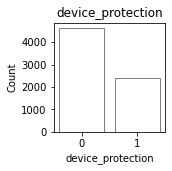

   device_protection  Count  Percent
0                  0   4621    65.61
1                  1   2422    34.39
_________________________________________________________________


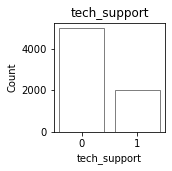

   tech_support  Count  Percent
0             0   4999    70.98
1             1   2044    29.02
_________________________________________________________________


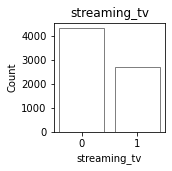

   streaming_tv  Count  Percent
0             0   4336    61.56
1             1   2707    38.44
_________________________________________________________________


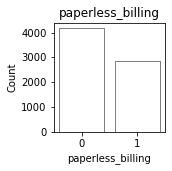

   paperless_billing  Count  Percent
1                  0   4171    59.22
0                  1   2872    40.78
_________________________________________________________________


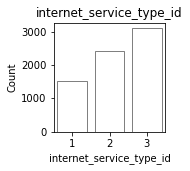

   internet_service_type_id  Count  Percent
2                         3   3096    43.96
1                         2   2421    34.37
3                         1   1526    21.67
_________________________________________________________________


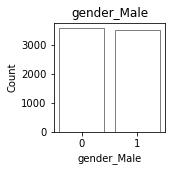

   gender_Male  Count  Percent
1            0   3555    50.48
0            1   3488    49.52
_________________________________________________________________


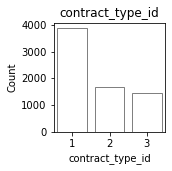

   contract_type_id  Count  Percent
1                 1   3875    55.02
3                 2   1695    24.07
2                 3   1473    20.91
_________________________________________________________________


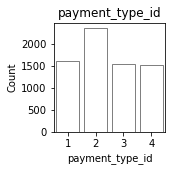

   payment_type_id  Count  Percent
1                2   2365    33.58
2                1   1612    22.89
3                3   1544    21.92
4                4   1522    21.61
_________________________________________________________________


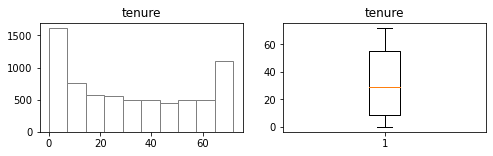

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64


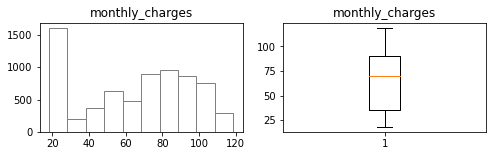

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64


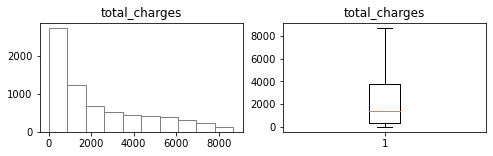

count    7043.000000
mean     2279.798992
std      2266.730170
min        18.800000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: total_charges, dtype: float64


In [10]:
explore.explore_univariate(prepped_telco, cat_vars, quant_vars)

In [14]:
#Step 1 is to split the data into my train, validate, and test data frames:
train, validate, test = explore.train_validate_test_split(prepped_telco, target='churn', seed=123)

In [15]:
cat_vars = cat_vars[1:]

partner 
_____________________

        chi2       p-value  degrees of freedom
0  80.757472  2.551912e-19                   1

observed:
 churn       0     1   All
partner                  
0        1379   668  2047
1        1518   378  1896
All      2897  1046  3943

expected:
              0           1
0  1503.971342  543.028658
1  1393.028658  502.971342


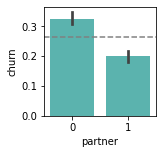


_____________________

dependents 
_____________________

         chi2       p-value  degrees of freedom
0  113.542825  1.640986e-26                   1

observed:
 churn          0     1   All
dependents                  
0           1925   878  2803
1            972   168  1140
All         2897  1046  3943

expected:
              0           1
0  2059.419478  743.580522
1   837.580522  302.419478


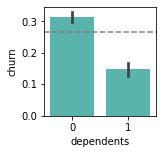


_____________________

phone_service 
_____________________

       chi2  p-value  degrees of freedom
0  2.261794   0.1326                   1

observed:
 churn             0     1   All
phone_service                  
0               289    87   376
1              2608   959  3567
All            2897  1046  3943

expected:
              0           1
0   276.254628   99.745372
1  2620.745372  946.254628


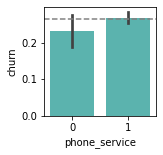


_____________________

multiple_lines 
_____________________

        chi2   p-value  degrees of freedom
0  12.907454  0.000327                   1

observed:
 churn              0     1   All
multiple_lines                  
0               1719   553  2272
1               1178   493  1671
All             2897  1046  3943

expected:
              0           1
0  1669.283287  602.716713
1  1227.716713  443.283287


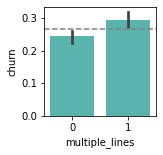


_____________________

online_security 
_____________________

         chi2       p-value  degrees of freedom
0  110.365313  8.149875e-26                   1

observed:
 churn               0     1   All
online_security                  
0                1900   868  2768
1                 997   178  1175
All              2897  1046  3943

expected:
              0           1
0  2033.704286  734.295714
1   863.295714  311.704286


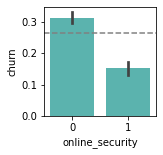


_____________________

online_backup 
_____________________

        chi2       p-value  degrees of freedom
0  25.943779  3.515064e-07                   1

observed:
 churn             0     1   All
online_backup                  
0              1813   747  2560
1              1084   299  1383
All            2897  1046  3943

expected:
              0           1
0  1880.882577  679.117423
1  1016.117423  366.882577


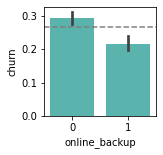


_____________________

device_protection 
_____________________

        chi2   p-value  degrees of freedom
0  23.374266  0.000001                   1

observed:
 churn                 0     1   All
device_protection                  
0                  1847   754  2601
1                  1050   292  1342
All                2897  1046  3943

expected:
              0           1
0  1911.006087  689.993913
1   985.993913  356.006087


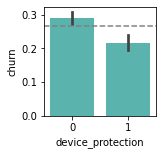


_____________________

tech_support 
_____________________

         chi2       p-value  degrees of freedom
0  105.401197  9.974962e-25                   1

observed:
 churn            0     1   All
tech_support                  
0             1913   868  2781
1              984   178  1162
All           2897  1046  3943

expected:
              0           1
0  2043.255643  737.744357
1   853.744357  308.255643


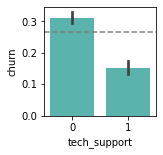


_____________________

streaming_tv 
_____________________

        chi2  p-value  degrees of freedom
0  17.447168  0.00003                   1

observed:
 churn            0     1   All
streaming_tv                  
0             1848   590  2438
1             1049   456  1505
All           2897  1046  3943

expected:
              0           1
0  1791.246766  646.753234
1  1105.753234  399.246766


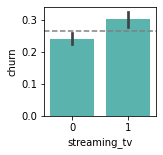


_____________________

paperless_billing 
_____________________

        chi2       p-value  degrees of freedom
0  152.19868  5.733280e-35                   1

observed:
 churn                 0     1   All
paperless_billing                  
0                  1350   258  1608
1                  1547   788  2335
All                2897  1046  3943

expected:
              0           1
0  1181.429369  426.570631
1  1715.570631  619.429369


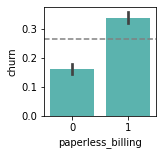


_____________________

internet_service_type_id 
_____________________

         chi2       p-value  degrees of freedom
0  408.384137  2.091758e-89                   2

observed:
 churn                        0     1   All
internet_service_type_id                  
1                         1094   239  1333
2                         1039   742  1781
3                          764    65   829
All                       2897  1046  3943

expected:
              0           1
0   979.381435  353.618565
1  1308.535886  472.464114
2   609.082678  219.917322


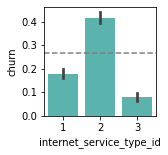


_____________________

gender_Male 
_____________________

       chi2   p-value  degrees of freedom
0  0.029156  0.864419                   1

observed:
 churn           0     1   All
gender_Male                  
0            1410   513  1923
1            1487   533  2020
All          2897  1046  3943

expected:
              0           1
0  1412.866092  510.133908
1  1484.133908  535.866092


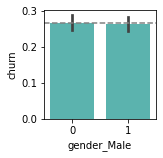


_____________________

contract_type_id 
_____________________

         chi2        p-value  degrees of freedom
0  625.295741  1.654837e-136                   2

observed:
 churn                0     1   All
contract_type_id                  
1                 1269   919  2188
2                  730   103   833
3                  898    24   922
All               2897  1046  3943

expected:
              0           1
0  1607.566827  580.433173
1   612.021557  220.978443
2   677.411616  244.588384


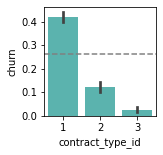


_____________________

payment_type_id 
_____________________

         chi2       p-value  degrees of freedom
0  388.493277  6.878635e-84                   3

observed:
 churn               0     1   All
payment_type_id                  
1                 724   612  1336
2                 730   161   891
3                 702   147   849
4                 741   126   867
All              2897  1046  3943

expected:
             0           1
0  981.585595  354.414405
1  654.635303  236.364697
2  623.777073  225.222927
3  637.002029  229.997971


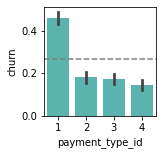


_____________________

tenure 
____________________



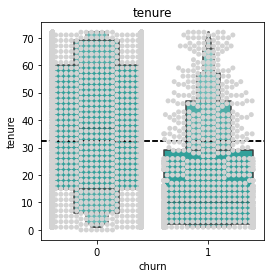

        count       mean        std  min   25%   50%   75%   max
churn                                                           
0      2897.0  37.492924  24.017001  0.0  15.0  37.0  60.0  72.0
1      1046.0  18.184512  19.555280  1.0   2.0  10.0  29.0  72.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=2232562.5, pvalue=1.612043074745637e-114)

____________________

monthly_charges 
____________________



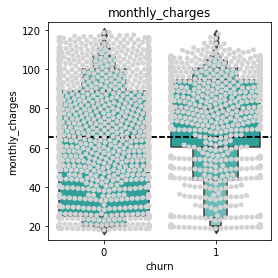

        count       mean        std    min     25%   50%    75%     max
churn                                                                  
0      2897.0  61.860476  30.988324  18.25  25.250  65.2  89.00  118.75
1      1046.0  75.072992  24.549408  18.95  60.625  79.9  94.25  117.80 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=1145311.0, pvalue=1.0243400926956932e-31)

____________________

total_charges 
____________________



In [ ]:
#Explore the bivariate variables
explore.explore_bivariate(train,'churn', cat_vars, quant_vars)